In [1]:
# Import necessary modules

%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import math

LOG.propagate = False

In [44]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2024-03-26 21:33:29,918 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:89:c5:6d:2f:4b
2024-03-26 21:33:34,450 | INFO     |: Connected to c0:89:c5:6d:2f:4b


In [45]:
tof_reading = []    # Stores the sensor reading in millimeters
motor_pwm = []      # Step response PWM value set manually
timestamp = []      # Timestamps in seconds

def notification_handler(uuid, byte_array):
    tof_reading.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[0])))
    motor_pwm.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[1])))
    timestamp.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[-1]))/1000)

ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

In [46]:
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

In [48]:
tof_reading.clear()
motor_pwm.clear()
timestamp.clear()

ble.send_command(CMD.START_MOTOR_CTRL, "")

In [49]:
ble.send_command(CMD.MOTOR_PMW_SET, "180")

In [50]:
ble.send_command(CMD.STOP_MOTOR_CTRL, "")

In [51]:
ble.send_command(CMD.GET_MOTOR_TOF_INFO, "")

In [56]:
data_N = len(timestamp)
print("sample interval: ", (timestamp[-1]-timestamp[0])/(data_N-1))

sample interval:  0.04817948717948475


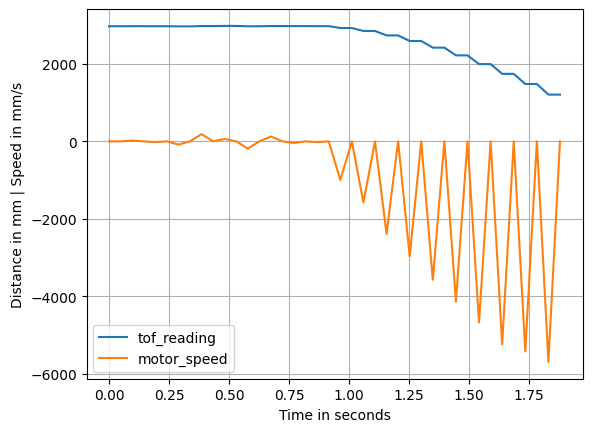

In [59]:
data_N = len(timestamp)

time = np.linspace(0., (timestamp[-1] - timestamp[0]), num=data_N)
motor_speed = []
for i in range(data_N):
    if (i == 0):
        motor_speed.append(0.)
    else:
        motor_speed.append((tof_reading[i] - tof_reading[i-1])/(time[i] - time[i-1]))

# Time domain figure
# plt.plot(time, motor_pwm, label='motor_pwm')
plt.plot(time, tof_reading, label='tof_reading')
plt.plot(time, motor_speed, label='motor_speed')
plt.legend()
plt.grid()
# plt.xlim([2000, 15000])
# plt.ylim([-500, 800])
plt.title('')
plt.xlabel('Time in seconds')
plt.ylabel('Distance in mm | Speed in mm/s')
plt.show()

#### Kalman Filter Initialization

In [42]:
# Calculate the drag and momentum terms
u = 1          # Assume u=1 for now
x_dot = 3700   # steady-state speed in mm/s
t_90 = 1.0    # 90% rise time in seconds

d = u/x_dot
m = -d*t_90/math.log(0.1)
print("d: {:.5f}, m: {:.5f}".format(d, m))

d: 0.00027, m: 0.00012


In [141]:
# Compute the A and B matrices
A = np.array([[0, 1], [0, -d/m]])
B = np.array([[0], [1/m]])
print("A: ", A, "B: ", B, "", sep='\n')

# Discretize A and B matrices
Delta_t = 0.098        # Sampling time being 0.098s
Ad = np.eye(2) + Delta_t * A
Bd = Delta_t * B
print("Ad: ", Ad, "Bd: ", Bd, sep='\n')

A: 
[[ 0.          1.        ]
 [ 0.         -2.30258509]]
B: 
[[   0.        ]
 [8519.56484408]]

Ad: 
[[1.         0.098     ]
 [0.         0.77434666]]
Bd: 
[[  0.        ]
 [834.91735472]]


In [142]:
# Identify C matrix
C = np.array([[-1,0]])

In [183]:
# Specify the process noise and sensor noise covariance matrices
# Process noise
sigma_1 = math.sqrt(100/Delta_t)
sigma_2 = math.sqrt(100/Delta_t)
# sigma_1 = 1
# sigma_2 = 1
sig_u=np.array([[sigma_1**2,0],[0,sigma_2**2]]) # assuming uncorrelated noise

# Measurement noise
sigma_3 = 20
sig_z=np.array([[sigma_3**2]])

print("sig_u: ", sig_u, "sig_z: ", sig_z, sep='\n')

sig_u: 
[[3061.2244898    0.       ]
 [   0.        3061.2244898]]
sig_z: 
[[400]]


#### Implement and Test the Kalman Filter

In [93]:
def kf(mu,sigma,u,y):
    
    # prediction
    mu_p = Ad.dot(mu) + Bd.dot(u) 
    sigma_p = Ad.dot(sigma.dot(Ad.transpose())) + sig_u

    # update
    sigma_m = C.dot(sigma_p.dot(C.transpose())) + sig_z
    kkf_gain = sigma_p.dot(C.transpose().dot(np.linalg.inv(sigma_m)))
    y_m = y-C.dot(mu_p)
    mu = mu_p + kkf_gain.dot(y_m)
    sigma=(np.eye(2)-kkf_gain.dot(C)).dot(sigma_p)

    return mu,sigma

In [169]:
# Scale the input value
pwm_u = [pwm/180 for pwm in motor_pwm]

# Initialial state
x = np.array([[-tof_reading[0]],[0]])
sig = np.array([[10**2,0],[0,10**2]])

# Loop through the data and call the Kalman Filter
kf_est = []
for pwm, tof in zip(pwm_u, tof_reading):
    x, sig = kf(x, sig, [[pwm]], [[tof]])
    kf_est.append(-x[0][0])

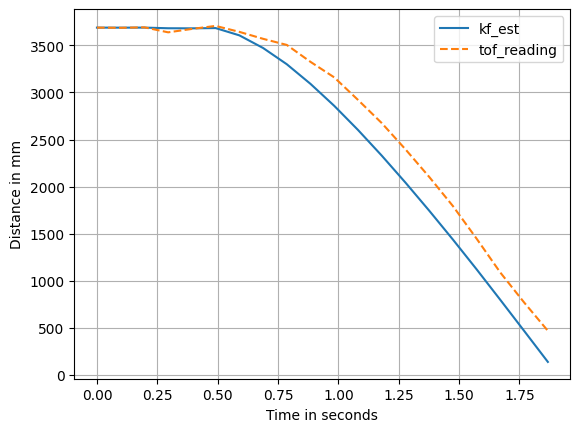

In [170]:
# Time domain figure
plt.plot(time, kf_est, label='kf_est')
plt.plot(time, tof_reading,  '--', label='tof_reading')
plt.legend()
plt.grid()
# plt.xlim([2000, 15000])
# plt.ylim([-500, 800])
plt.title('')
plt.xlabel('Time in seconds')
plt.ylabel('Distance in mm')
plt.show()

#### Using Kalman Filter Outputs to Estimate between ToF readings

In [207]:
# Interpolate between the original timestamps
interpolated_timestamp = []
interpolated_tof = []
interpolated_pwm = []
time_intervals = np.diff(time)

for i in range(data_N - 1):
    interpolated_timestamp.append(time[i])
    interpolated_timestamp.append(time[i] + time_intervals[i] / 3)
    interpolated_timestamp.append(time[i] + time_intervals[i] *2/3)

    interpolated_tof.append(tof_reading[i])
    interpolated_tof.append(0.)
    interpolated_tof.append(0.)

    interpolated_pwm.append(motor_pwm[i])
    interpolated_pwm.append(motor_pwm[i])
    interpolated_pwm.append(motor_pwm[i])
    
interpolated_timestamp.append(time[-1])
interpolated_tof.append(tof_reading[-1])
interpolated_pwm.append(motor_pwm[-1])

In [219]:
# Discretize A and B matrices
Delta_t = 0.098/3        # Interpolated
Ad = np.eye(2) + Delta_t * A
Bd = Delta_t * B
print("Ad: ", Ad, "Bd: ", Bd, sep='\n')

Ad: 
[[1.         0.03266667]
 [0.         0.92478222]]
Bd: 
[[  0.        ]
 [278.30578491]]


In [245]:
# Specify the process noise and sensor noise covariance matrices
# Process noise
sigma_1 = math.sqrt(100/Delta_t)
sigma_2 = math.sqrt(100/Delta_t)
# sigma_1 = 1
# sigma_2 = 1
sig_u=np.array([[sigma_1**2,0],[0,sigma_2**2]]) # assuming uncorrelated noise

# Measurement noise
sigma_3 = 20
sig_z=np.array([[sigma_3**2]])

print("sig_u: ", sig_u, "sig_z: ", sig_z, sep='\n')

sig_u: 
[[3061.2244898    0.       ]
 [   0.        3061.2244898]]
sig_z: 
[[400]]


In [28]:
def kf_estimation(mu,sigma,u,y,update_flag):
    # prediction
    mu_p = Ad.dot(mu) + Bd.dot(u) 
    sigma_p = Ad.dot(sigma.dot(Ad.transpose())) + sig_u

    # update only when there is a valid ToF reading
    if (update_flag):
        sigma_m = C.dot(sigma_p.dot(C.transpose())) + sig_z
        kkf_gain = sigma_p.dot(C.transpose().dot(np.linalg.inv(sigma_m)))
        y_m = y-C.dot(mu_p)
        mu = mu_p + kkf_gain.dot(y_m)
        sigma=(np.eye(2)-kkf_gain.dot(C)).dot(sigma_p)
    # otherwise just do prediction
    else:
        mu = mu_p
        sigma=sigma_p

    return mu,sigma

In [250]:
# Initialial state
x = np.array([[-tof_reading[0]],[0]])
sig = np.array([[10**2,0],[0,10**2]])

# Loop through the data and call the Kalman Filter
kf_est_faster = []
for pwm, tof in zip(interpolated_pwm, interpolated_tof):
    if (tof!=0.):
        x, sig = kf_estimation(x, sig, [[pwm/180]], [[tof]], True)
    else:
        x, sig = kf_estimation(x, sig, [[pwm/180]], [[tof]], False)

    kf_est_faster.append(-x[0][0])

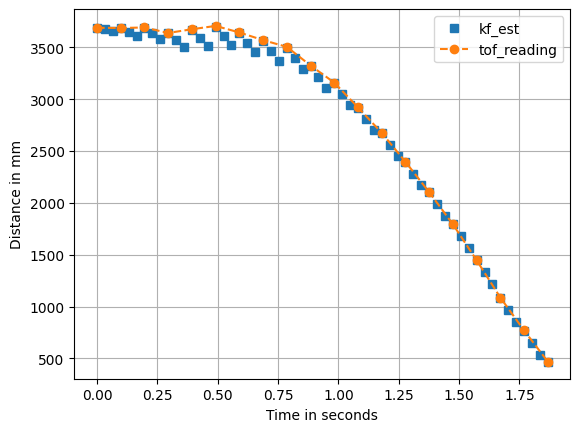

In [249]:
# Time domain figure
plt.plot(interpolated_timestamp, kf_est_faster, 's', label='kf_est')
plt.plot(time, tof_reading,  '--o', label='tof_reading')
plt.legend()
plt.grid()
# plt.xlim([2000, 15000])
# plt.ylim([-500, 800])
plt.title('')
plt.xlabel('Time in seconds')
plt.ylabel('Distance in mm')
plt.show()

In [3]:
tof_reading = []    # Stores the sensor reading in millimeters
tof_extrapolation = []
pid_ctrl = []      # Step response PWM value set manually
timestamp = []      # Timestamps in seconds

def notification_handler_(uuid, byte_array):
    tof_reading.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[0])))
    tof_extrapolation.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[1])))
    pid_ctrl.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[2])))
    timestamp.append(((float) (ble.bytearray_to_string(byte_array).split(", ")[-1]))/1000)

ble.start_notify(ble.uuid['RX_STRING'], notification_handler_)

In [260]:
ble.start_notify(ble.uuid['RX_STRING'], notification_handler_)

In [17]:
ble.send_command(CMD.KP_SET, "0.3")

In [18]:
ble.send_command(CMD.KI_SET, "0.001")

In [19]:
ble.send_command(CMD.KD_SET, "100")

In [20]:
ble.send_command(CMD.REF_POS_SET, "500")

In [21]:
tof_reading.clear()
tof_extrapolation.clear()
pid_ctrl.clear()
timestamp.clear()

ble.send_command(CMD.START_TOF_PID, "")

In [22]:
ble.send_command(CMD.STOP_TOF_PID, "")

In [23]:
ble.send_command(CMD.GET_TOF_PID_INFO, "")

In [25]:
timestamp[-1]-timestamp[0]

1.7319999999999993

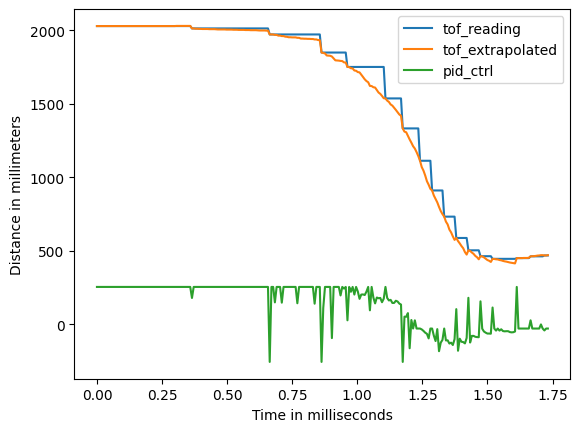

In [26]:
tof_N = len(tof_reading)

# Time domain figure
time = np.linspace(0., (timestamp[-1] - timestamp[0]), num=tof_N)
plt.plot(time, tof_reading, label='tof_reading')
plt.plot(time, tof_extrapolation, label='tof_extrapolated')
plt.plot(time, pid_ctrl, label='pid_ctrl')
# plt.plot(time, np.linspace(304, 304, num=tof_N), label='ref_pos')
plt.legend()
plt.title('')
# plt.xlim(0, 2000)
# plt.ylim(-300, 2000)
plt.xlabel('Time in milliseconds')
plt.ylabel('Distance in millimeters')
plt.show()

In [29]:
# Calculate the drag and momentum terms
u = 1          # Assume u=1 for now
x_dot = 3700   # steady-state speed in mm/s
t_90 = 1.0    # 90% rise time in seconds

d = u/x_dot
m = -d*t_90/math.log(0.1)
print("d: {:.5f}, m: {:.5f}".format(d, m))

d: 0.00027, m: 0.00012


In [30]:
# Compute the A and B matrices
A = np.array([[0, 1], [0, -d/m]])
B = np.array([[0], [1/m]])
print("A: ", A, "B: ", B, "", sep='\n')

# Discretize A and B matrices
Delta_t = (timestamp[-1]-timestamp[0])/(len(timestamp)-1)        # Sampling time being 0.098s
Ad = np.eye(2) + Delta_t * A
Bd = Delta_t * B
print("Ad: ", Ad, "Bd: ", Bd, sep='\n')

A: 
[[ 0.          1.        ]
 [ 0.         -2.30258509]]
B: 
[[   0.        ]
 [8519.56484408]]

Ad: 
[[1.         0.00663602]
 [0.         0.98472001]]
Bd: 
[[ 0.        ]
 [56.53596287]]


In [31]:
# Identify C matrix
C = np.array([[-1,0]])

In [32]:
# Specify the process noise and sensor noise covariance matrices
# Process noise
sigma_1 = math.sqrt(100/Delta_t)
sigma_2 = math.sqrt(100/Delta_t)
# sigma_1 = 1
# sigma_2 = 1
sig_u=np.array([[sigma_1**2,0],[0,sigma_2**2]]) # assuming uncorrelated noise

# Measurement noise
sigma_3 = 20
sig_z=np.array([[sigma_3**2]])

print("sig_u: ", sig_u, "sig_z: ", sig_z, sep='\n')

sig_u: 
[[15069.28406467     0.        ]
 [    0.         15069.28406467]]
sig_z: 
[[400]]


In [38]:
# Initialial state
x = np.array([[-tof_reading[0]],[0]])
sig = np.array([[10**2,0],[0,10**2]])

# Loop through the data and call the Kalman Filter
kf_est_faster = []
tof_prev = tof_reading[0]
for pwm,tof in zip(pid_ctrl, tof_reading):
    if (tof!=tof_prev):
        x, sig = kf_estimation(x, sig, [[pwm/255]], [[tof]], True)
        tof_prev = tof
    else:
        x, sig = kf_estimation(x, sig, [[pwm/255]], [[tof]], False)

    kf_est_faster.append(-x[0][0])

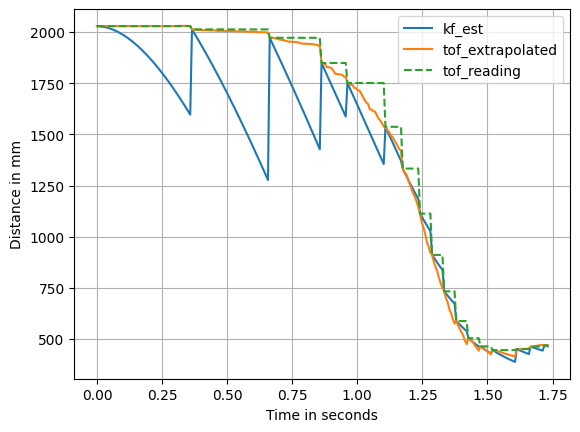

2024-03-26 19:55:01,887 | INFO     |: Disconnected from C0:89:C5:6D:2F:4B


In [41]:
# Time domain figure
plt.plot(time, kf_est_faster, '', label='kf_est')
plt.plot(time, tof_extrapolation, label='tof_extrapolated')
plt.plot(time, tof_reading,  '--', label='tof_reading')
plt.legend()
plt.grid()
plt.title('')
plt.xlabel('Time in seconds')
plt.ylabel('Distance in mm')
plt.show()